# Count epitope mutations by trunk status for simulated populations

For a given tree, classify each node as trunk or not and count the number of epitope and non-epitope mutations. Finally, summarize the number of mutations by category of trunk and mutation.

In [1]:
from augur.distance import read_distance_map
from augur.utils import json_to_tree
import Bio.Phylo
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

## Load tree data

In [2]:
with open("../results/auspice/flu_simulated_simulated_sample_3_full_tree_2040-10-01_tree.json", "r") as fh:
    tree_json = json.load(fh)

In [3]:
tree = json_to_tree(tree_json)

In [4]:
tree

Clade(branch_length=0, clade=19276, name='NODE_0000001', numdate=2028.4722323774806, strain='NODE_0000001', yvalue=10751.816071098714)

## Load distance map

In [5]:
distance_map = read_distance_map("../config/distance_maps/h3n2/ha/luksza.json")

In [6]:
# Extract all epitope sites from the distance map, readjusting to one-based coordinates
# for comparison with one-based coordinates of amino acid mutations annotated on trees.
epitope_sites = [site + 1 for site in distance_map["map"]["HA1"].keys()]

In [7]:
np.array(epitope_sites)

array([ 50,  53,  54, 121, 122, 124, 126, 131, 133, 135, 137, 142, 143,
       144, 145, 146, 155, 156, 157, 158, 159, 160, 163, 164, 172, 173,
       174, 186, 188, 189, 190, 192, 193, 196, 197, 201, 207, 213, 217,
       226, 227, 242, 244, 248, 275, 276, 278, 299, 307])

In [8]:
", ".join([str(site) for site in epitope_sites[:-1]]) + ", and " + str(epitope_sites[-1])

'50, 53, 54, 121, 122, 124, 126, 131, 133, 135, 137, 142, 143, 144, 145, 146, 155, 156, 157, 158, 159, 160, 163, 164, 172, 173, 174, 186, 188, 189, 190, 192, 193, 196, 197, 201, 207, 213, 217, 226, 227, 242, 244, 248, 275, 276, 278, 299, and 307'

## Annotate number of epitope and non-epitope mutations per node

In [9]:
for node in tree.find_clades():
    epitope_mutations = 0
    nonepitope_mutations = 0
    
    if len(node.aa_muts) > 0:
        for gene, muts in node.aa_muts.items():
            for mut in muts:
                if gene == "HA1" and int(mut[1:-1]) in epitope_sites:
                    epitope_mutations += 1
                else:
                    nonepitope_mutations += 1
                    
    node.epitope_mutations = epitope_mutations
    node.nonepitope_mutations = nonepitope_mutations

In [10]:
set([node.epitope_mutations for node in tree.find_clades() if node.epitope_mutations > 0])

{1, 2, 3, 5}

## Assign trunk status

[Bedford et al. 2015](http://www.nature.com.offcampus.lib.washington.edu/nature/journal/v523/n7559/pdf/nature14460.pdf) defines trunk as "all branches ancestral to viruses
sampled within 1 year of the most recent sample". The algorithm for finding the trunk based on this definition is then:

  1. Select all nodes in the last year
  1. Select the parent of each selected node until the root
  1. Create a unique set of nodes
  1. Omit all nodes from the last year since resolution of the trunk is limited (note: this step is not implemented below)

Note that this definition was based on 12 years of flu data from 2000 to 2012.

In [11]:
max_date = max([tip.attr["num_date"] for tip in tree.find_clades(terminal=True)])

In [12]:
max_date

2040.74

In [13]:
# Find all tips of the tree sampled within a year of the most recent sample in the tree.
recent_nodes = [node for node in tree.find_clades(terminal=True) if node.attr["num_date"] > (max_date - 1)]

In [14]:
len(recent_nodes)

1080

In [15]:
# Find the last common ancestor of all recent nodes.
mrca = tree.common_ancestor(recent_nodes)

In [16]:
mrca

Clade(branch_length=0.06771649285334287, clade=19134, epitope_mutations=0, name='NODE_0009343', nonepitope_mutations=0, numdate=2038.0206324862932, strain='NODE_0009343', yvalue=1338.1353990231582)

In [17]:
mrca.attr["num_date"]

2038.0206324862932

In [18]:
# Label all nodes as not part of the trunk by default.
for node in tree.find_clades():
    node.is_trunk = False
    node.is_side_branch_ancestor = False

In [19]:
# Find all nodes that are ancestral to recent nodes.
# Label these ancestral nodes as part of the "trunk"
# and collect the set of distinct nodes in the trunk.
for recent_node in recent_nodes:
    current_node = recent_node.parent
    
    # Traverse from the current node to the tree's root.
    while current_node != tree.root:
        # Mark a node as part of the trunk if it was sampled
        # before the MRCA of all recent nodes.
        if current_node.attr["num_date"] < mrca.attr["num_date"]:
            current_node.is_trunk = True
            
        current_node = current_node.parent

In [20]:
def is_side_branch_ancestor(node):
    """Returns True if the current node belongs to a "side branch" clade
    and is the immediate descendent from a trunk.
    """
    return node.parent is not None and node.parent.is_trunk

In [21]:
trunk_path = [node for node in tree.find_clades(terminal=False)
              if node.is_trunk]

In [22]:
# Find all nodes that are not on the trunk. These are
# side branch nodes.
side_branch_nodes = [node for node in tree.find_clades(terminal=False)
                     if not node.is_trunk and node.attr["num_date"] < mrca.attr["num_date"]]

In [23]:
len(trunk_path)

141

In [24]:
len(side_branch_nodes)

6199

In [25]:
# Find all side branch nodes whose immediate parent is on the trunk.
side_branch_ancestors = []
for node in side_branch_nodes:
    if is_side_branch_ancestor(node):
        node.is_side_branch_ancestor = True
        side_branch_ancestors.append(node)

In [26]:
len(side_branch_ancestors)

174

In [27]:
# Color nodes by status as on the trunk or as a side branch ancestor.
for node in tree.find_clades():
    if node.is_trunk:
        node.color = "green"
    elif node.is_side_branch_ancestor:
        node.color = "orange"
    else:
        node.color = "black"

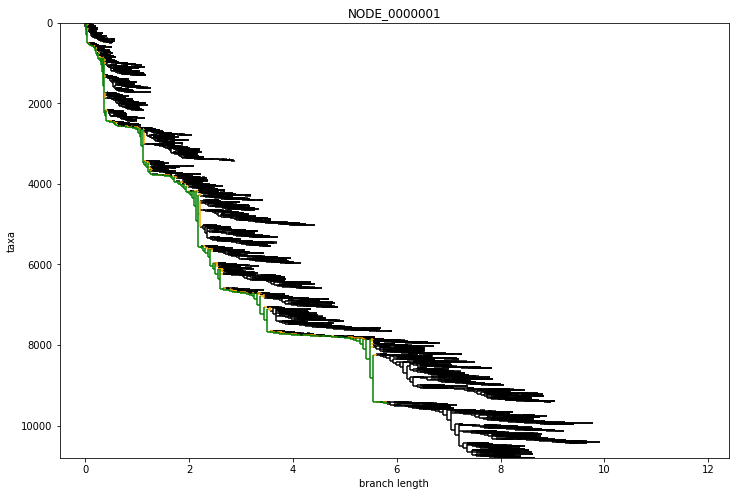

In [28]:
# Draw tree with node colors instead of with node labels.
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
Bio.Phylo.draw(tree, axes=ax, label_func=lambda node: "")

## Annotate mutations by trunk status

In [29]:
records = []
for node in tree.find_clades(terminal=False):
    # Collect records for nodes that are on the trunk or that were sampled prior
    # to the MRCA of recent nodes (i.e., side branch nodes).
    if node.is_trunk or node.attr["num_date"] < mrca.attr["num_date"]:
        records.append({
            "node": node.name,
            "branch type": "trunk" if node.is_trunk else "side branch",
            "epitope mutations": node.epitope_mutations,
            "non-epitope mutations": node.nonepitope_mutations
        })

In [30]:
df = pd.DataFrame(records)

In [31]:
df.head()

,branch type,epitope mutations,node,non-epitope mutations
0,side branch,0,NODE_0000001,0
1,side branch,5,NODE_0000013,5
2,side branch,1,NODE_0000014,1
3,side branch,0,NODE_0000010,1
4,side branch,1,NODE_0000011,0


In [32]:
counts_by_trunk_status = df.groupby("branch type").aggregate({"epitope mutations": "sum", "non-epitope mutations": "sum"})

In [33]:
counts_by_trunk_status["epitope-to-non-epitope ratio"] = round(
    counts_by_trunk_status["epitope mutations"] / counts_by_trunk_status["non-epitope mutations"]
, 2)

In [34]:
counts_by_trunk_status

,epitope mutations,non-epitope mutations,epitope-to-non-epitope ratio
branch type,,,
side branch,590,1327,0.44
trunk,23,12,1.92


In [35]:
counts_by_trunk_status_table = counts_by_trunk_status.to_latex(escape=False)

with open("../manuscript/tables/mutations_by_trunk_status_for_simulated_populations.tex", "w") as oh:
    oh.write(counts_by_trunk_status_table)